![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4210_Analisis_con_Deep_Learning/blob/master/lab_3/practica_6/practica_6_reg.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>

## **Práctica 6**

## **Aprendizaje por Transferencia - Regresión**

## **Objetivos**
- Introducción al uso de arquitecturas preentrenadas para el aprendizaje por transferencia.
- Usar TFRecord como método de carga eficiente de datos.
- Introducción a la localización de objetos mediante regresión.
- Callbacks personalizados.
- Optimización y tácticas de Boosting.
- Tensorflow functions y graph mode

## **Problema**
- En un dataset de aves, se busca clasificar a cada una de ellas entre 200 categorías.

In [ ]:
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
import setup_colab_general as setup_general
setup_general.setup_general()

shred: setup_colab_general.py: failed to open for writing: No such file or directory


  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


In [ ]:
!pip install -q tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


## **Importando las librerías necesarias para el laboratorio**

In [ ]:
import numpy as np
import pandas as pd

from google.colab import files

import os

from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

from utils import general as gen
import cv2

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

from typing import Optional, Any, List, Tuple

In [ ]:
train_id = "1PVp5_TdXIt31A_Buyb-P12wZjLkZJBy6"
val_id = "1ARg5k_wH5Q0gwxB1uP58x6wyTX3-6maz"
test_id = "1QbxUS_mv_GWGQQ0rgazQHymAj9ni05f9"

In [ ]:
gen.download_file_from_google_drive(train_id, "train.tfrec")
gen.download_file_from_google_drive(val_id, "val.tfrec")
gen.download_file_from_google_drive(test_id, "test.tfrec")

0KB [00:00, ?KB/s]

0KB [00:00, ?KB/s]

0KB [00:00, ?KB/s]

## **Lectura, Visualización y Procesamiento**
- Como ya se vio en la práctica extra de TFRecord, es un tipo de archivo para leer datos de manera eficiente en el buffer de entrenamiento. En esta ocasión, utilizaremos el TFRecord generado en dicha práctica. 

In [ ]:
SHAPE = (224, 224)
BATCH_SIZE = 64
N_CLASSES = 200
TRAIN_SIZE = 3860
VAL_SIZE = 966
TEST_SIZE = 1207

In [ ]:
train_ds = tf.data.TFRecordDataset(
    "data/train.tfrec", 
    num_parallel_reads=16
)
val_ds = tf.data.TFRecordDataset(
    "data/val.tfrec", 
    num_parallel_reads=16
)
test_ds = tf.data.TFRecordDataset(
    "data/test.tfrec", 
    num_parallel_reads=16
)

In [ ]:
@tf.function
def parse_image_function(
    example_input
) -> Optional[Tuple[tf.Tensor]]:
    """
    TF Function to parse a TFRecord 
    serialized single example
    :param example_input: The serialized TF 
    Example to be parsed
    :type example_input: Optional[tf.Tensor]
    :return: The resulting image, label 
    and bbox of the parsed Example
    :rtype: Optional[Tuple[tf.Tensor]]
    """
    # We extract the feature description from the example
    # represented by features of fixed length and fixed type
    image_feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }

    # We parse example by example
    feature = tf.io.parse_single_example(
        example_input, image_feature_description
    )

    # We get the features from the feature dict
    image = feature["image"]
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, SHAPE)

    label = tf.cast(feature["class"], tf.int32)

    return image, label

@tf.function
def augment_data(
    image: Optional[tf.Tensor], 
    label: Optional[tf.Tensor]
) -> Optional[Tuple[tf.Tensor]]:
    """
    Function to process the image and label
    :param image: The image to be processed
    :type image: Optional[tf.Tensor]
    :param label: The label of the image
    :type label: Optional[tf.Tensor]
    :return: The image processed and the label
    :rtype: Optional[Tuple[tf.Tensor]]
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

def performance(
    dataset: Optional[tf.data.Dataset], 
    train: bool = True
) -> Optional[tf.data.Dataset]:
    """
    Function to boost dataset load performance
    :param dataset: The dataset to be boosted
    :type dataset: Optional[tf.data.Dataset]
    :param train: Flag to indicate the nature of the dataset
    :type train: bool
    :return: The dataset boosted
    :rtype: Optional[tf.data.Dataset]
    """
    if train:
        # Shuffle the dataset to a fixed buffer sample
        dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
        # The number of batches that will be parallel processed
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    # Repeat the incidences in the dataset
    dataset = dataset.repeat()
    # Create batches from dataset
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [ ]:
train_ds = train_ds.map(parse_image_function).map(augment_data)
val_ds = val_ds.map(parse_image_function)
test_ds = test_ds.map(parse_image_function)

In [ ]:
for img, label in train_ds.take(5):
    tf.print("Image shape:", tf.shape(img))
    tf.print("Label:", label)

Image shape: [224 224 3]
Label: 77
Image shape: [224 224 3]
Label: 114
Image shape: [224 224 3]
Label: 195
Image shape: [224 224 3]
Label: 27
Image shape: [224 224 3]
Label: 135


In [ ]:
imgs = []
labels = []

for img, label in train_ds.take(9):
    labels.append(label.numpy())
    imgs.append(img.numpy())

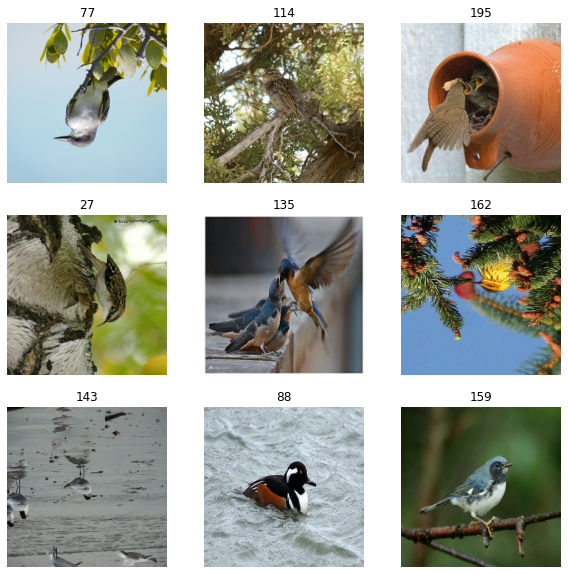

In [ ]:
gen.visualize_subplot(
    imgs, labels,
    (3, 3), (10, 10),
)

In [ ]:
train_ds = performance(train_ds)
val_ds = performance(val_ds, False)
test_ds = performance(test_ds, False)

## **Modelamiento**
- Inception:

![image](https://cloud.google.com/tpu/docs/images/inceptionv3onc--oview.png?hl=es)

In [ ]:
base_model = keras.applications.NASNetMobile(
    input_shape=(*SHAPE, 3),
    include_top=False,
    weights="imagenet",
)

global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dense_1 = keras.layers.Dense(128, activation="relu")(global_avg)
dense_2 = keras.layers.Dense(64, activation="relu")(dense_1)
dense_out = keras.layers.Dense(N_CLASSES, activation="softmax")(dense_2)

model = keras.Model(inputs=base_model.input, outputs=dense_out)

lr = 1e-5
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"]
)

20004864/19993432 [==============================] - 0s 0us/step


In [ ]:
if not os.path.exists("models"):
    os.makedirs("models")

weights_dir = "models/weights.h5"

In [ ]:
model.summary()

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, weights_dir, patience=10, rate=0.5):
        """
        Initializer Method
        :param weights_dir: The directory of the model weights
        :param patience: Number of epochs before reducing lr
        :param rate: The rate to reduce the lr
        """
        super(CustomCallback, self).__init__()
        self.weights_dir = weights_dir
        self.rate = rate
        self.patience = patience

    def on_train_begin(self, logs=None):
        """
        Configurations to be taken an account on
        before training begins.
        :param logs: The logs from the output.
        """
        self.best_loss = np.Inf
        self.wait = 0
        self.best_weights = None
    
    def on_epoch_end(self, epoch, logs=None):
        """
        Method that is called each time an epoch ends
        excecution
        :param epoch: The current epoch of the training
        :param logs: The logs from the output from an epoch ended
        """
        # Current validation loss
        current_loss = logs.get("val_loss")
        if current_loss < self.best_loss:
            # We save the model weights
            # We wait again
            # We assign the best loss and the best recall.
            self.wait = 0
            self.best_loss = current_loss
            self.model.save_weights(self.weights_dir)
            self.best_weights = self.model.get_weights()
            print("\nBest Weights Saved!!")
        else:
            self.wait += 1
            if self.wait >= self.patience:
                # Reduce learning rate by the initialized rate.
                self.wait = 0
                print(f"\nEpoch {epoch}, Reducing Learning Rate")
                # We set the new learning rate
                lr = K.get_value(self.model.optimizer.lr)
                new_lr = lr * self.rate
                K.set_value(self.model.optimizer.lr, new_lr)
                print(f"\nLearning Rate Reduced: {new_lr}")
                # We load the best weights to continue the training.
                self.model.set_weights(self.best_weights)
                print("\nBest Weights Loaded!!")

In [ ]:
train_params = {
    "steps_per_epoch": TRAIN_SIZE // BATCH_SIZE,
    "validation_steps": VAL_SIZE // BATCH_SIZE,
    "epochs": 50,
    "validation_data": val_ds,
    "callbacks": [CustomCallback(weights_dir)]
}

In [ ]:
model.fit(train_ds, **train_params)

In [ ]:
files.download("models/weights.h5")

## **Validación y Predicción**

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, steps=TEST_SIZE // BATCH_SIZE)